In [10]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from lyric_model import CNNModel
from vocab import Vocabulary, build_vocab
from lyrics_dataset import LyricsDataset, build_lyrics_df
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from lstm_model import LSTMModel
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

In [11]:

root_dir = '/Users/zhangmingyin/Desktop/lyric/ml_lyrics'
data = build_lyrics_df(root_dir)

vocab = Vocabulary()
vocab = build_vocab(data, vocab)

dataset = LyricsDataset(data, vocab, 0)

In [12]:
embedding_dim = 100  # Example dimension, adjust as per your GloVe file
# Initialize an embedding matrix with random values
embedding_matrix = np.random.rand(len(vocab), embedding_dim)

glove_path = '/Users/zhangmingyin/Desktop/lyric/glove.6B.100d.txt'

embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Populate embedding matrix with GloVe embeddings
for word, idx in vocab.word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

# Convert embedding matrix to PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [13]:
print(len(vocab))
print(embedding_matrix.shape)

11112
torch.Size([11112, 100])


In [33]:
from torch.nn.utils.rnn import pad_sequence

def create_mask(padded_sequence, padding_value=0):
    """
    Creates a mask for the filled sequence.

    Parameters.
    padded_sequence (torch.Tensor): the padded sequence, in the shape (batch_size, seq_len).
    padding_value (int): the value to be used for padding, default is 0.

    Returns.
    torch.Tensor: mask tensor, shape (batch_size, seq_len).
    """
    mask = (padded_sequence == padding_value)
    return mask

def collate_fn(data):
    """
    Custom collate_fn function that processes batch data and generates masks.

    Parameters.
    data (list): list of input data.
    max_len (int): Maximum sequence length.

    Returns: tuple
    tuple: the processed sequence tensor, sentiment tensor and mask tensor.
    """
    lyrics, moods = zip(*data)
    
    truncated_lyrics = [lyric[:512] for lyric in lyrics]
    
    padded_lyrics = pad_sequence([lyric.clone().detach() for lyric in truncated_lyrics], batch_first=True, padding_value=0)
    
    mask = create_mask(padded_lyrics, padding_value=0)
    moods = torch.stack(moods)

    return padded_lyrics, mask, moods


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes, embedding_matrix, num_heads=5, num_layers=2):
        super(TransformerClassifier, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=0)
        
        self.position_embedding = nn.Embedding(512, embed_size)  
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc = nn.Linear(embed_size, num_classes)

    def forward(self, x, mask):
        seq_length = x.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=x.device)
        position_ids = position_ids.unsqueeze(0).expand_as(x)
        
        embedded = self.embedding(x) + self.position_embedding(position_ids)
        embedded = embedded.permute(1, 0, 2)  # Transformer expects input shape: (seq_length, batch_size, embed_size)
        
        # Apply the mask
        transformer_output = self.transformer_encoder(embedded, src_key_padding_mask=mask)
        
        transformer_output = transformer_output.permute(1, 0, 2)  # Back to (batch_size, seq_length, embed_size)
        
        pooled_output = F.avg_pool1d(transformer_output.transpose(1, 2), kernel_size=transformer_output.size(1)).squeeze(2)  # (batch_size, embed_size)
        
        out = self.fc(pooled_output)  # (batch_size, num_classes)
        return out


In [43]:

train_ratio = 0.8
test_ratio = 1 - train_ratio

total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,collate_fn=collate_fn)

print( len(train_dataset))
print( len(test_dataset))

训练集大小: 1557
测试集大小: 390


In [49]:
model = TransformerClassifier(vocab_size=len(vocab), embed_size=embedding_dim, num_classes=4, embedding_matrix=embedding_matrix)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

/Users/zhangmingyin/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [45]:
from sklearn.metrics import accuracy_score


train_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []
train_losses = []

test_accuracies = []
test_precisions = []
test_recalls = []
test_f1s = []
test_losses = []

num_epochs = 30

def train_model(model, train_loader, test_loader, criterion, optimizer,scheduler, num_epochs=30):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        for i, (lyrics, masks, mood) in enumerate(train_loader):
            optimizer.zero_grad()
            lyrics, mood = lyrics.to(model.device), mood.to(model.device)
            outputs = model(lyrics, masks)
            loss = criterion(outputs, mood)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = torch.sigmoid(outputs)  
            preds = (preds > 0.5).float()  
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(mood.cpu().numpy())
        
        
        # Calculate training accuracy
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        train_accuracies.append(accuracy)
        train_precisions.append(precision)
        train_recalls.append(recall)
        train_f1s.append(f1)
        train_losses.append(total_loss / len(train_loader))
        scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}, Accuracy: {accuracy * 100:.2f}%,Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%, F1 Score: {f1 * 100:.2f}%')
        
        test_accuracy, test_precision, test_recall, test_f1,test_loss = evaluate_model(model, test_loader, criterion)
        test_accuracies.append(test_accuracy)
        test_precisions.append(test_precision)
        test_recalls.append(test_recall)
        test_f1s.append(test_f1)
        test_losses.append(test_loss)
        
        

def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for lyrics, masks, mood  in test_loader:
            
            lyrics, mood = lyrics.to(model.device), mood.to(model.device)
            outputs = model(lyrics, masks)
            loss = criterion(outputs, mood)
            total_loss += loss.item()

            preds = torch.sigmoid(outputs)  
            preds = (preds > 0.5).float()  
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(mood.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    average_loss = total_loss / len(test_loader)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%,Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%, F1 Score: {f1 * 100:.2f}%')
    return accuracy, precision, recall, f1, average_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.device = device  

train_model(model, train_loader, test_loader, criterion, optimizer,scheduler, num_epochs)


/Users/zhangmingyin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30, Loss: 0.5449795278967643, Accuracy: 7.96%,Precision: 43.19%, Recall: 9.17%, F1 Score: 14.73%


/Users/zhangmingyin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.4188, Test Accuracy: 34.10%,Precision: 41.25%, Recall: 33.46%, F1 Score: 36.81%
Epoch 2/30, Loss: 0.33255638942426563, Accuracy: 54.78%,Precision: 73.61%, Recall: 56.64%, F1 Score: 61.73%
Test Loss: 0.3180, Test Accuracy: 57.95%,Precision: 83.11%, Recall: 60.85%, F1 Score: 60.94%
Epoch 3/30, Loss: 0.22869364902073022, Accuracy: 76.62%,Precision: 82.99%, Recall: 80.30%, F1 Score: 81.52%
Test Loss: 0.1941, Test Accuracy: 83.59%,Precision: 86.25%, Recall: 85.99%, F1 Score: 85.97%
Epoch 4/30, Loss: 0.12158908816624661, Accuracy: 91.97%,Precision: 93.34%, Recall: 92.61%, F1 Score: 92.97%
Test Loss: 0.1886, Test Accuracy: 84.36%,Precision: 88.37%, Recall: 87.11%, F1 Score: 86.84%
Epoch 5/30, Loss: 0.07510412149891561, Accuracy: 95.63%,Precision: 96.50%, Recall: 95.82%, F1 Score: 96.16%
Test Loss: 0.1316, Test Accuracy: 90.77%,Precision: 91.68%, Recall: 91.68%, F1 Score: 91.60%
Epoch 6/30, Loss: 0.053375960916888954, Accuracy: 96.72%,Precision: 97.67%, Recall: 97.24%, F1 Score: 9

In [46]:
import torch

model_path = '/Users/zhangmingyin/Desktop/lyric/data_model/model_tansformer.pt'
data_path = '/Users/zhangmingyin/Desktop/lyric/data_model/training_tansformer.pt'

torch.save(model.state_dict(), model_path)

training_data = {
    'train_accuracies': train_accuracies,
    'train_precisions': train_precisions,
    'train_recalls': train_recalls,
    'train_f1s': train_f1s,
    'train_losses': train_losses,
    'test_accuracies': test_accuracies,
    'test_precisions': test_precisions,
    'test_recalls': test_recalls,
    'test_f1s': test_f1s,
    'test_losses': test_losses
}

torch.save(training_data, data_path)

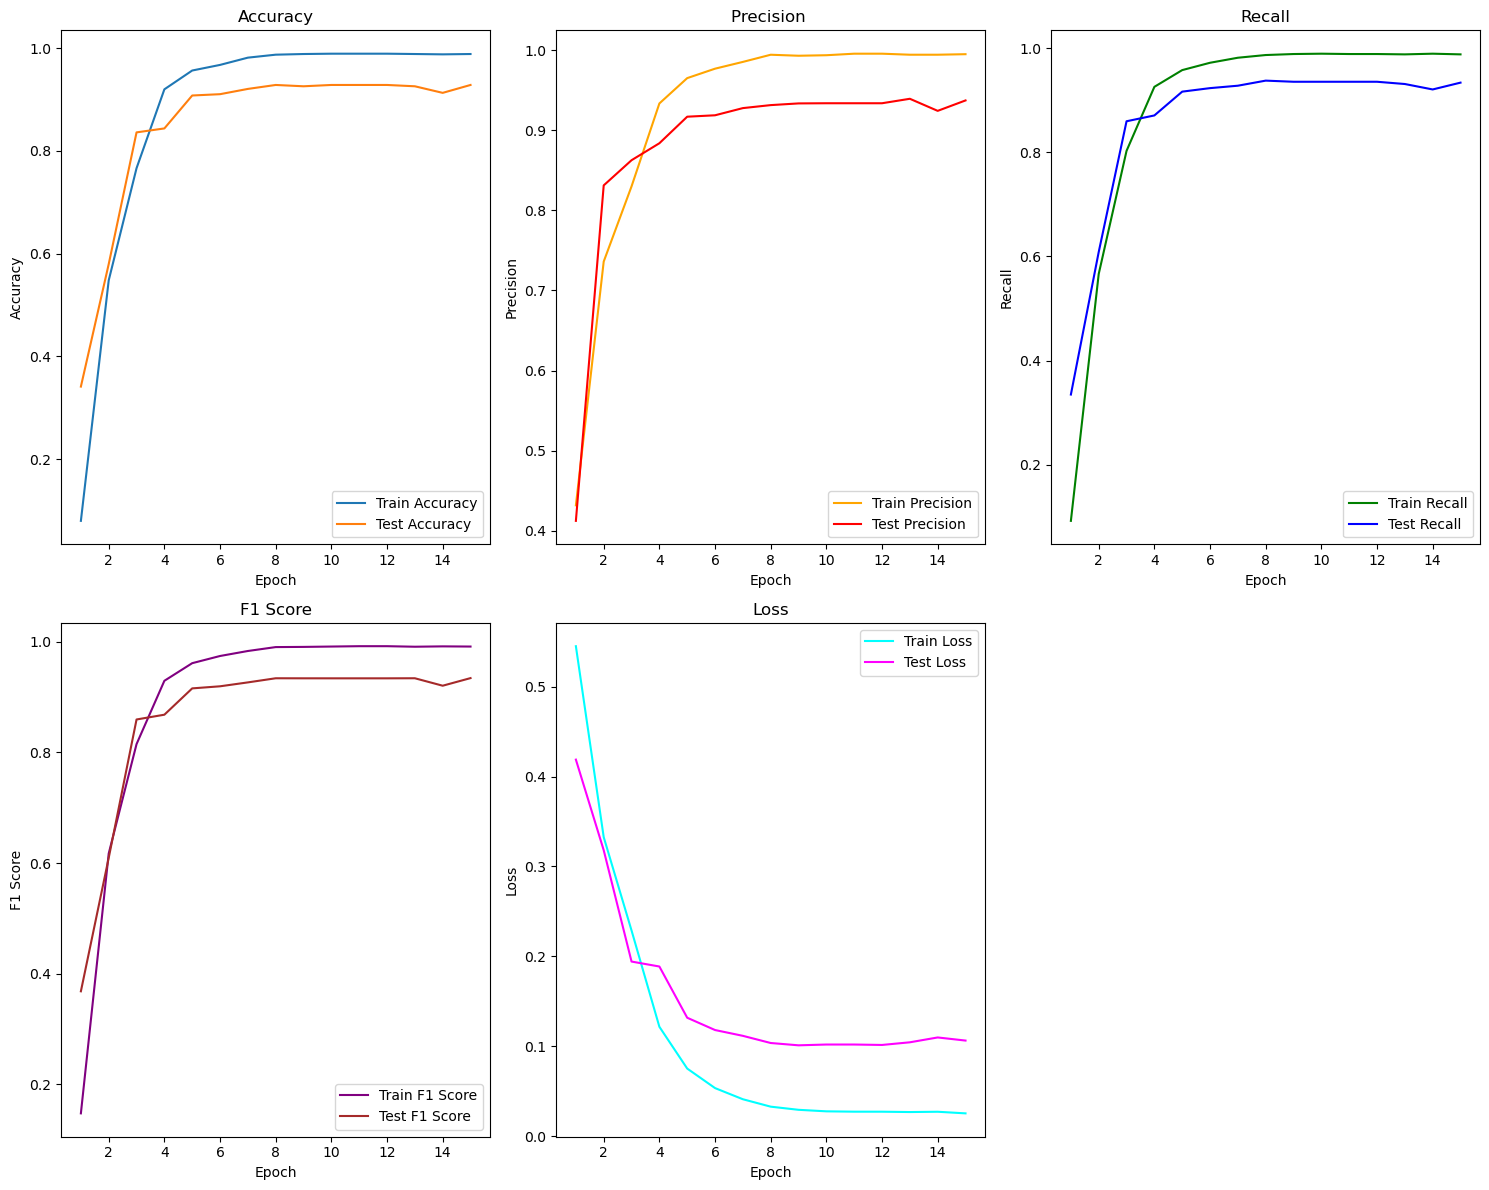

In [59]:
import torch
import matplotlib.pyplot as plt

training_data = torch.load('/Users/zhangmingyin/Desktop/lyric/data_model/training_tansformer.pt')

num_epochs = min(15, len(training_data['train_accuracies'])) 

train_accuracies = training_data['train_accuracies'][:num_epochs]
train_precisions = training_data['train_precisions'][:num_epochs]
train_recalls = training_data['train_recalls'][:num_epochs]
train_f1s = training_data['train_f1s'][:num_epochs]
train_losses = training_data['train_losses'][:num_epochs]

test_accuracies = training_data['test_accuracies'][:num_epochs]
test_precisions = training_data['test_precisions'][:num_epochs]
test_recalls = training_data['test_recalls'][:num_epochs]
test_f1s = training_data['test_f1s'][:num_epochs]
test_losses = training_data['test_losses'][:num_epochs]

indices = range(1, num_epochs + 1)

plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
plt.plot(indices, train_accuracies, label='Train Accuracy')
plt.plot(indices, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(indices, train_precisions, label='Train Precision', color='orange')
plt.plot(indices, test_precisions, label='Test Precision', color='red')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision ')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(indices, train_recalls, label='Train Recall', color='green')
plt.plot(indices, test_recalls, label='Test Recall', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(indices, train_f1s, label='Train F1 Score', color='purple')
plt.plot(indices, test_f1s, label='Test F1 Score', color='brown')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(indices, train_losses, label='Train Loss', color='cyan')
plt.plot(indices, test_losses, label='Test Loss', color='magenta')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:

model.load_state_dict(torch.load('/Users/zhangmingyin/Desktop/lyric/data_model/model_tansformer.pt'))
model.eval()

y_true = []
y_proba = []
y_pred = []

with torch.no_grad():
    for data, mask, labels in test_loader:
        outputs = model(data, mask)
        probabilities = torch.softmax(outputs, dim=1)  
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.numpy())
        y_proba.extend(probabilities.numpy())
        y_pred.extend(predicted.numpy())

y_true = np.array(y_true, dtype=int)
y_proba = np.array(y_proba)
y_pred = np.array(y_pred)

In [56]:
print(f"y_true shape: {y_true.shape}")
print(f"y_proba shape: {y_proba.shape}")


y_true shape: (390, 4)
y_proba shape: (390, 4)


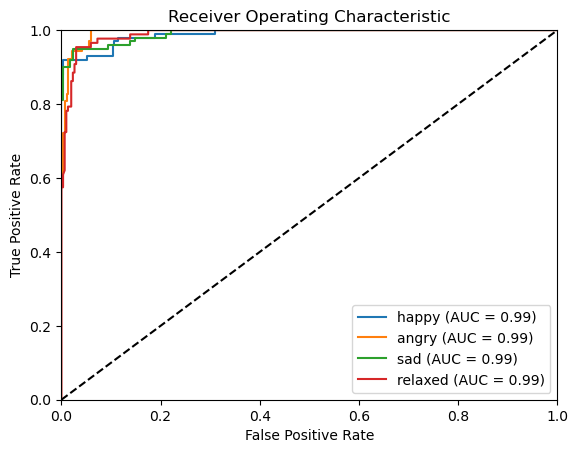

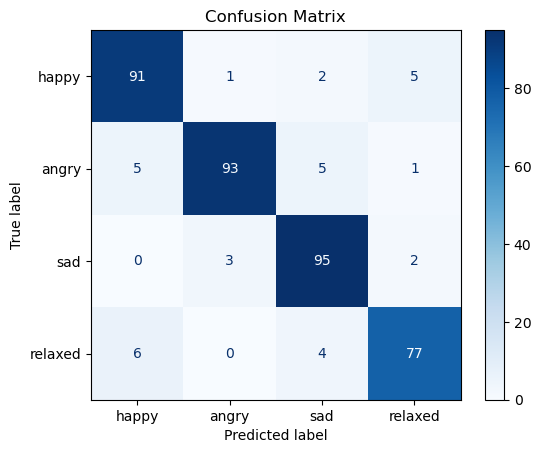

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay


classes = ["happy", "angry", "sad", "relaxed"]


def plot_roc_curve(y_true, y_proba, classes):
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    plt.figure()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

y_pred = np.argmax(y_proba, axis=1)  

plot_roc_curve(y_true, y_proba, classes)

plot_confusion_matrix(y_true, y_pred, classes)
